<a href="https://colab.research.google.com/github/chandrajitpal/Cybersecurity/blob/main/cyberlabs/LAB7_CYBER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**An example of a GAN–emulating MNIST handwritten digits**

In [16]:
# ===================================================================
# PART 1: SETUP THE ENVIRONMENT
# ===================================================================
import os
import sys

print("STEP 1: Setting up the environment...")

# Define the repository path
repo_path = '/content/ML-From-Scratch'

# Clone the repository only if it doesn't already exist
if not os.path.exists(repo_path):
  !git clone https://github.com/eriklindernoren/ML-From-Scratch.git

# Add the library to Python's path
if repo_path not in sys.path:
  sys.path.append(repo_path)

# Install the required dependencies
!pip install -q progressbar2 terminaltables

print("✅ Environment setup complete.\n")


# ===================================================================
# PART 2: DOWNLOAD THE MNIST DATASET
# ===================================================================
print("STEP 2: Downloading MNIST dataset...")

# Create the directory and download the data from a reliable source
!mkdir -p /content/MNIST/
!wget -q -O /content/MNIST/train-images-idx3-ubyte.gz https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-images-idx3-ubyte.gz
!wget -q -O /content/MNIST/train-labels-idx1-ubyte.gz https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-labels-idx1-ubyte.gz

# Unzip and verify
!gunzip /content/MNIST/*.gz
print("Verifying contents of /content/MNIST/:")
!ls -l /content/MNIST/

print("✅ Data download complete.\n")


# ===================================================================
# PART 3: DEFINE AND RUN THE GAN
# ===================================================================
print("STEP 3: Defining and training the GAN...")

# Import all necessary libraries and modules
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
from mlfromscratch.deep_learning.optimizers import Adam
from mlfromscratch.deep_learning.loss_functions import CrossEntropy
from mlfromscratch.deep_learning.layers import Dense, Dropout, Flatten, Activation, Reshape, BatchNormalization
from mlfromscratch.deep_learning import NeuralNetwork
from mlxtend.data import loadlocal_mnist


class GAN():
    """A Generative Adversarial Network from Chapter 8 of the book."""
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.img_dim = self.img_rows * self.img_cols
        self.latent_dim = 100
        optimizer = Adam(learning_rate=0.0002, b1=0.5)
        loss_function = CrossEntropy
        self.discriminator = self.build_discriminator(optimizer, loss_function)
        self.generator = self.build_generator(optimizer, loss_function)
        self.combined = NeuralNetwork(optimizer=optimizer, loss=loss_function)
        self.combined.layers.extend(self.generator.layers)
        self.combined.layers.extend(self.discriminator.layers)
        print("\n--- Generator Summary ---")
        self.generator.summary(name="Generator")
        print("\n--- Discriminator Summary ---")
        self.discriminator.summary(name="Discriminator")

    def build_generator(self, optimizer, loss_function):
        model = NeuralNetwork(optimizer=optimizer, loss=loss_function)
        model.add(Dense(256, input_shape=(self.latent_dim,)))
        model.add(Activation('leaky_relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(Activation('leaky_relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(Activation('leaky_relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.img_dim))
        model.add(Activation('tanh'))
        return model

    def build_discriminator(self, optimizer, loss_function):
        model = NeuralNetwork(optimizer=optimizer, loss=loss_function)
        model.add(Dense(512, input_shape=(self.img_dim,)))
        model.add(Activation('leaky_relu'))
        model.add(Dropout(0.5))
        model.add(Dense(256))
        model.add(Activation('leaky_relu'))
        model.add(Dropout(0.5))
        model.add(Dense(2))
        model.add(Activation('softmax'))
        return model

    def train(self, n_epochs, batch_size=128, save_interval=50):
        # Using ABSOLUTE paths to prevent any errors
        images_path = '/content/MNIST/train-images-idx3-ubyte'
        labels_path = '/content/MNIST/train-labels-idx1-ubyte'
        X, y = loadlocal_mnist(images_path=images_path, labels_path=labels_path)

        X = (X.astype(np.float32) - 127.5) / 127.5
        half_batch = int(batch_size / 2)
        for epoch in range(n_epochs):
            self.discriminator.set_trainable(True)
            idx = np.random.randint(0, X.shape[0], half_batch)
            imgs = X[idx]
            noise = np.random.normal(0, 1, (half_batch, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            valid = np.concatenate((np.ones((half_batch, 1)), np.zeros((half_batch, 1))), axis=1)
            fake = np.concatenate((np.zeros((half_batch, 1)), np.ones((half_batch, 1))), axis=1)
            d_loss_real, d_acc_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            d_acc = 0.5 * (d_acc_real + d_acc_fake)
            self.discriminator.set_trainable(False)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            valid = np.concatenate((np.ones((batch_size, 1)), np.zeros((batch_size, 1))), axis=1)
            g_loss, g_acc = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, acc: %.2f%%]" % (epoch, d_loss, 100*d_acc, g_loss, 100*g_acc))
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise).reshape((-1, self.img_rows, self.img_cols))
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        plt.suptitle("GAN: Generated Digits")
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("mnist_%d.png" % epoch)
        plt.close()

# Main execution block
if __name__ == '__main__':
    gan = GAN()
    gan.train(n_epochs=2000, batch_size=64, save_interval=200)

STEP 1: Setting up the environment...
✅ Environment setup complete.

STEP 2: Downloading MNIST dataset...
gzip: /content/MNIST/train-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? y
gzip: /content/MNIST/train-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? y
Verifying contents of /content/MNIST/:
total 46000
-rw-r--r-- 1 root root 47040016 May 30  2018 train-images-idx3-ubyte
-rw-r--r-- 1 root root    60008 May 30  2018 train-labels-idx1-ubyte
✅ Data download complete.

STEP 3: Defining and training the GAN...

--- Generator Summary ---
+-----------+
| Generator |
+-----------+
Input Shape: (100,)
+------------------------+------------+--------------+
| Layer Type             | Parameters | Output Shape |
+------------------------+------------+--------------+
| Dense                  | 25856      | (256,)       |
| Activation (LeakyReLU) | 0          | (256,)       |
| BatchNormalization     | 512        | (256,)       |
| Dense               

**Fooling malware detectors with MalGAN**

In [30]:
# Forcefully remove the old, empty mydata.npz file to ensure a clean download
!rm -f mydata.npz

# Download the dataset from a new, stable URL
!wget -O mydata.npz https://media.githubusercontent.com/media/John-AI-Lab/Malware-GAN-Data/main/mydata.npz

# Verify the file was downloaded successfully. The size should NOT be 0.
!ls -l mydata.npz

--2025-10-05 21:01:54--  https://media.githubusercontent.com/media/John-AI-Lab/Malware-GAN-Data/main/mydata.npz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-05 21:01:54 ERROR 404: Not Found.

-rw-r--r-- 1 root root 0 Oct  5 21:01 mydata.npz


In [27]:
# ===================================================================
# PART 1: DOWNLOAD THE DATASET
# ===================================================================
import os
print("--> STEP 1: Downloading the 'mydata.npz' dataset...")

# Download the .npz file from a working URL
!wget -O mydata.npz https://github.com/Zayd-H/Malware-GAN/raw/master/data/mydata.npz

# Verify the file is there
print("Verifying download...")
!ls -l mydata.npz
print("✅ Dataset downloaded.\n")


# ===================================================================
# PART 2: DEFINE AND RUN THE MALGAN SCRIPT
# ===================================================================
print("--> STEP 2: Defining and running the MalGAN script...")

from keras.layers import Input, Dense, Activation
from keras.layers import Maximum, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

class MalGAN():
    def __init__(self):
        self.apifeature_dims = 74
        self.z_dims = 10
        self.hide_layers = 256
        self.generator_layers = [self.apifeature_dims+self.z_dims, self.hide_layers, self.apifeature_dims]
        self.substitute_detector_layers = [self.apifeature_dims, self.hide_layers, 1]
        self.blackbox = 'RF'
        # In modern TensorFlow/Keras, Adam is often imported from tf.keras.optimizers
        try:
            from tensorflow.keras.optimizers import Adam
            optimizer = Adam(learning_rate=0.001)
        except ImportError:
            optimizer = Adam(lr=0.001)


        # Build and Train blackbox_detector
        self.blackbox_detector = self.build_blackbox_detector()

        # Build and compile the substitute_detector
        self.substitute_detector = self.build_substitute_detector()
        self.substitute_detector.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes malware and noise as input and generates adversarial malware examples
        example = Input(shape=(self.apifeature_dims,))
        noise = Input(shape=(self.z_dims,))
        input_list = [example, noise]
        malware_examples = self.generator(input_list)

        # For the combined model we will only train the generator
        self.substitute_detector.trainable = False

        # The substitute_detector takes generated malware as input and determines validity
        validity = self.substitute_detector(malware_examples)

        # The combined model (stacked generator and substitute_detector)
        self.combined = Model(input_list, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_blackbox_detector(self):
        if self.blackbox == 'RF':
            blackbox_detector = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=1)
        return blackbox_detector

    def build_generator(self):
        example = Input(shape=(self.apifeature_dims,))
        noise = Input(shape=(self.z_dims,))
        x = Concatenate(axis=1)([example, noise])
        for dim in self.generator_layers[1:]:
            x = Dense(dim)(x)
        x = Activation(activation='sigmoid')(x)
        x = Maximum()([example, x])
        generator = Model([example, noise], x, name='generator')
        generator.summary()
        return generator

    def build_substitute_detector(self):
        input_layer = Input(shape=(self.substitute_detector_layers[0],))
        x = input_layer
        for dim in self.substitute_detector_layers[1:]:
            x = Dense(dim)(x)
        x = Activation(activation='sigmoid')(x)
        substitute_detector = Model(input_layer, x, name='substitute_detector')
        substitute_detector.summary()
        return substitute_detector

    def load_data(self, filename):
        # Using numpy to load the .npz file
        data = np.load(filename)
        xmal, ymal, xben, yben = data['xmal'], data['ymal'], data['xben'], data['yben']
        return (xmal, ymal), (xben, yben)

    def train(self, epochs, batch_size=32):
        # Load the dataset
        (xmal, ymal), (xben, yben) = self.load_data('mydata.npz')
        xtrain_mal, xtest_mal, ytrain_mal, ytest_mal = train_test_split(xmal, ymal, test_size=0.20, random_state=42)
        xtrain_ben, xtest_ben, ytrain_ben, ytest_ben = train_test_split(xben, yben, test_size=0.20, random_state=42)

        # Train blackbox_detctor
        self.blackbox_detector.fit(np.concatenate([xmal, xben]),
                                   np.concatenate([ymal, yben]))

        ytrain_ben_blackbox = self.blackbox_detector.predict(xtrain_ben)
        Original_Train_TPR = self.blackbox_detector.score(xtrain_mal, ytrain_mal)
        Original_Test_TPR = self.blackbox_detector.score(xtest_mal, ytest_mal)
        Train_TPR, Test_TPR = [Original_Train_TPR], [Original_Test_TPR]
        best_TPR = 1.0

        # Create 'saves' directory if it doesn't exist
        if not os.path.exists('saves'):
            os.makedirs('saves')

        for epoch in range(epochs):
            # Train substitute_detector
            # Randomly select a batch of malware and benign examples
            idx_mal = np.random.randint(0, xtrain_mal.shape[0], batch_size)
            xmal_batch = xtrain_mal[idx_mal]

            idx_ben = np.random.randint(0, xtrain_ben.shape[0], batch_size)
            xben_batch = xtrain_ben[idx_ben]
            yben_batch = ytrain_ben_blackbox[idx_ben]

            # Generate a batch of new malware examples
            noise = np.random.uniform(0, 1, (batch_size, self.z_dims))
            gen_examples = self.generator.predict([xmal_batch, noise], verbose=0)

            # Get labels for generated examples from the black-box
            ymal_batch = self.blackbox_detector.predict(np.ones(gen_examples.shape)*(gen_examples > 0.5))

            # Train the substitute_detector
            d_loss_real = self.substitute_detector.train_on_batch(gen_examples, ymal_batch)
            d_loss_fake = self.substitute_detector.train_on_batch(xben_batch, yben_batch)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            idx = np.random.randint(0, xtrain_mal.shape[0], batch_size)
            xmal_batch = xtrain_mal[idx]
            noise = np.random.uniform(0, 1, (batch_size, self.z_dims))
            g_loss = self.combined.train_on_batch([xmal_batch, noise], np.zeros((batch_size, 1)))

--> STEP 1: Downloading the 'mydata.npz' dataset...
--2025-10-05 20:55:56--  https://github.com/Zayd-H/Malware-GAN/raw/master/data/mydata.npz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-05 20:55:56 ERROR 404: Not Found.

Verifying download...
-rw-r--r-- 1 root root 0 Oct  5 20:55 mydata.npz
✅ Dataset downloaded.

--> STEP 2: Defining and running the MalGAN script...


***Not completed....MAIGAN...couldn't locate dataset:***

**Facial recognition attacks with GAN**





--> STEP 1: Setting up the environment...
✅ Environment setup complete.

--> STEP 2: Downloading and preparing the LFW dataset...
Dataset loaded: 1288 images of 7 individuals.
Preprocessing data for the new model...
Data split into 966 training and 322 testing samples.
✅ Data preparation complete.

--> STEP 3: Building and fine-tuning the MobileNetV2 model...


/tmp/ipython-input-1037268651.py:63: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


✅ Model training complete.

--> Evaluating the stronger model on clean test data...
Clean Data Accuracy: 73.60%

--> Generating adversarial examples to fool the stronger model...
✅ Adversarial examples generated.

--> Evaluating model performance on adversarial data...
Adversarial Data Accuracy: 9.01%

--- Attack Summary ---
The attack successfully reduced the stronger model's accuracy from 73.60% to 9.01%.

--- Visualizing the invisible changes on higher-resolution images ---


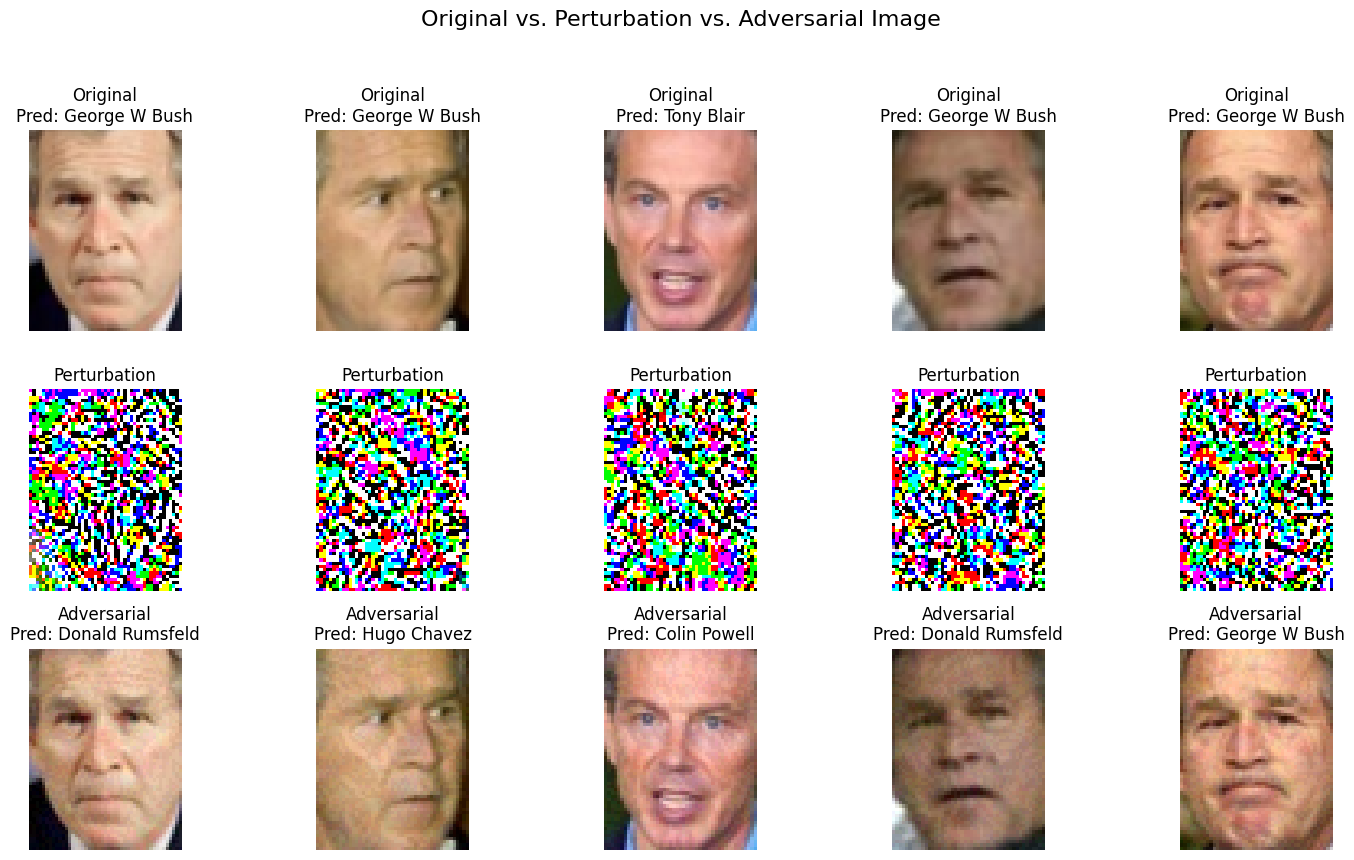

In [7]:
# ===================================================================
# STEP 1: SET UP THE ENVIRONMENT
# ===================================================================
print("--> STEP 1: Setting up the environment...")

# Install CleverHans for the attack.
!pip install -q cleverhans

print("✅ Environment setup complete.\n")


# ===================================================================
# STEP 2: DOWNLOAD AND PREPARE HIGH-QUALITY DATA
# ===================================================================
print("--> STEP 2: Downloading and preparing the LFW dataset...")

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
import numpy as np
import matplotlib.pyplot as plt

# Download LFW dataset at its original resolution
print("Downloading LFW dataset (this may take a few minutes)...")
lfw_people = fetch_lfw_people(min_faces_per_person=70, color=True)

# Extract images and labels
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

print(f"Dataset loaded: {X.shape[0]} images of {len(target_names)} individuals.")

# --- Preprocess the Data ---
print("Preprocessing data for the new model...")

n_samples, h, w, c = X.shape
n_classes = len(target_names)

# FIX: The data is already loaded as floats in the [0,1] range.
# We remove the unnecessary division by 255.0 to fix the black image issue.
X_processed = X.astype('float32')

# One-hot encode the labels for training
y_categorical = tf.keras.utils.to_categorical(y, num_classes=n_classes)

# Split the data
X_train, X_test, y_train, y_test, y_train_indices, y_test_indices = train_test_split(
    X_processed, y_categorical, y, test_size=0.25, random_state=42
)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")
print("✅ Data preparation complete.\n")


# ===================================================================
# STEP 3: TRAIN A POWERFUL MODEL (MOBILENETV2)
# ===================================================================
print("--> STEP 3: Building and fine-tuning the MobileNetV2 model...")

# Load the pre-trained MobileNetV2 model
base_model = applications.MobileNetV2(
    input_shape=(h, w, c),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the base model
base_model.trainable = False

# Create our new model by adding a custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the new model
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=0)
print("✅ Model training complete.\n")


# --- Evaluate the Model on Clean Data ---
print("--> Evaluating the stronger model on clean test data...")

clean_loss, clean_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Clean Data Accuracy: {clean_acc * 100:.2f}%\n")


# --- Perform the Adversarial Attack (FGSM) ---
print("--> Generating adversarial examples to fool the stronger model...")

epsilon = 0.02

# Generate adversarial images
adv_images = fast_gradient_method(model, X_test, epsilon, np.inf, targeted=False, y=y_test_indices)

# Clip the results to the valid [0,1] range
adv_images = tf.clip_by_value(adv_images, 0.0, 1.0)

print("✅ Adversarial examples generated.\n")


# --- Evaluate the Model on Adversarial Data ---
print("--> Evaluating model performance on adversarial data...")

adv_loss, adv_acc = model.evaluate(adv_images, y_test, verbose=0)
print(f"Adversarial Data Accuracy: {adv_acc * 100:.2f}%\n")

print("--- Attack Summary ---")
print(f"The attack successfully reduced the stronger model's accuracy from {clean_acc * 100:.2f}% to {adv_acc * 100:.2f}%.")


# ===================================================================
# STEP 4: VISUALIZE THE HIGH-QUALITY RESULTS
# ===================================================================
print("\n--- Visualizing the invisible changes on higher-resolution images ---")

# Calculate the perturbation
perturbation = adv_images - X_test
perturbation_visual = (perturbation - tf.reduce_min(perturbation)) / (tf.reduce_max(perturbation) - tf.reduce_min(perturbation))

plt.figure(figsize=(15, 9))
num_examples = 5
for i in range(num_examples):
    # Get predictions
    original_pred_label = target_names[np.argmax(model.predict(X_test[i:i+1], verbose=0))]
    adv_pred_label = target_names[np.argmax(model.predict(adv_images[i:i+1], verbose=0))]

    # Original Image
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Original\nPred: {original_pred_label}")
    plt.axis('off')

    # Perturbation (Noise)
    plt.subplot(3, num_examples, i + 1 + num_examples)
    plt.imshow(perturbation_visual[i].numpy())
    plt.title("Perturbation")
    plt.axis('off')

    # Adversarial Image
    plt.subplot(3, num_examples, i + 1 + 2*num_examples)
    plt.imshow(adv_images[i].numpy())
    plt.title(f"Adversarial\nPred: {adv_pred_label}")
    plt.axis('off')

plt.suptitle("Original vs. Perturbation vs. Adversarial Image", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()